In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, time, json
import pandas as pd
from openai import OpenAI
from tqdm.auto import tqdm

import sys
sys.path.append("../")
import os

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

from nnsight import LanguageModel
from src.models import ModelandTokenizer
from transformers import BitsAndBytesConfig

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}")
logger.info(f"{transformers.__version__=}")

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-04-23 10:41:47 __main__ INFO     torch.__version__='2.6.0+cu124', torch.version.cuda='12.4'
2025-04-23 10:41:47 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2025-04-23 10:41:47 __main__ INFO     transformers.__version__='4.51.3'


In [3]:
from src.functional import extract_entities_with_oracle_LM

# entity = "Leonardo da Vinci"
# entity = "Benjamin Franklin"
# entity = "Japan"
entity = "Daredevil"

keywords_gpt = extract_entities_with_oracle_LM(entity, oracle="gpt4o")
keywords_gpt

2025-04-23 10:41:47 httpx DEBUG    load_ssl_context verify=True cert=None trust_env=True http2=False
2025-04-23 10:41:47 httpx DEBUG    load_verify_locations cafile='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/certifi/cacert.pem'
2025-04-23 10:41:47 src.functional DEBUG    found cached gpt4o response for 93ba798cd545a644364989fde8874a7e - loading


[['Matt Murdock', "Daredevil's real name is Matt Murdock"],
 ['Marvel Comics',
  'Daredevil is a superhero character published by Marvel Comics'],
 ['Stan Lee', 'Daredevil was co-created by writer Stan Lee'],
 ['Bill Everett', 'Daredevil was co-created by artist Bill Everett'],
 ['1964', 'Daredevil first appeared in Daredevil #1 in 1964'],
 ["Hell's Kitchen",
  "Daredevil operates primarily in the Hell's Kitchen neighborhood of New York City"],
 ['Blindness',
  'Daredevil is blind due to a childhood accident involving radioactive material'],
 ['Enhanced Senses',
  'Daredevil has superhuman senses as a result of his accident'],
 ['Radar Sense',
  'Daredevil possesses a radar sense that compensates for his lack of sight'],
 ['Lawyer', 'Matt Murdock is a lawyer by profession'],
 ['Foggy Nelson',
  "Foggy Nelson is Matt Murdock's best friend and law partner"],
 ['Karen Page',
  "Karen Page is a significant love interest and secretary at Murdock's law firm"],
 ['The Kingpin', "The Kingpin i

In [4]:
keywords_claude = extract_entities_with_oracle_LM(entity, oracle="claude")
keywords_claude

2025-04-23 10:41:47 httpx DEBUG    load_ssl_context verify=True cert=None trust_env=True http2=False
2025-04-23 10:41:47 httpx DEBUG    load_verify_locations cafile='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/certifi/cacert.pem'
2025-04-23 10:41:47 src.functional DEBUG    found cached gpt4o response for 93ba798cd545a644364989fde8874a7e - loading


[['Matt Murdock', 'Daredevil is the superhero alter ego of Matt Murdock'],
 ['Marvel Comics', 'Daredevil is a character published by Marvel Comics'],
 ['Stan Lee', 'Daredevil was co-created by Stan Lee'],
 ['Bill Everett', 'Daredevil was co-created by Bill Everett'],
 ['Blindness',
  'Daredevil is blind, having lost his sight in a childhood accident'],
 ['Enhanced Senses',
  'Daredevil possesses superhuman senses (hearing, smell, touch, taste) that compensate for his blindness'],
 ['Radar Sense',
  'Daredevil has a radar-like sense that allows him to perceive his surroundings'],
 ["Hell's Kitchen",
  "Daredevil operates primarily in the Hell's Kitchen neighborhood of New York City"],
 ['Lawyer', 'Matt Murdock is a lawyer by profession'],
 ['Nelson & Murdock',
  'Matt Murdock co-founded the law firm Nelson & Murdock with Foggy Nelson'],
 ['Foggy Nelson',
  "Franklin 'Foggy' Nelson is Matt Murdock's best friend and law partner"],
 ['Karen Page',
  'Karen Page is a close ally, love intere

In [5]:
####################################
# entity = "Japan"
# other_entity = "Germany"

# entity = "Benjamin Franklin"
# other_entity = "Leonardo da Vinci"

entity = "Daredevil"
other_entity = "Toph Beifong"
####################################

In [6]:
connections_gpt = extract_entities_with_oracle_LM(entity, oracle="gpt4o", other_entity=other_entity)
connections_gpt

2025-04-23 10:41:51 httpx DEBUG    load_ssl_context verify=True cert=None trust_env=True http2=False
2025-04-23 10:41:51 httpx DEBUG    load_verify_locations cafile='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/certifi/cacert.pem'
2025-04-23 10:41:51 src.functional DEBUG    found cached gpt4o response for 3b7b60a93afa6cf934d6eb80528e1d6e - loading


[['Blindness',
  'Both Daredevil and Toph Beifong are characters who are blind but have developed extraordinary abilities that compensate for their lack of sight.'],
 ['Enhanced Senses',
  'Daredevil and Toph Beifong both have heightened senses that allow them to perceive the world in unique ways despite their blindness.'],
 ['Fictional Characters',
  "Both are fictional characters from popular media: Daredevil from Marvel Comics and Toph Beifong from the animated series 'Avatar: The Last Airbender'."],
 ['Martial Arts',
  'Both characters are skilled in martial arts; Daredevil is a trained fighter, and Toph is a master earthbender who uses her bending in combat.'],
 ['Justice',
  'Both characters are associated with themes of justice; Daredevil is a vigilante fighting crime, while Toph is part of a group that seeks to bring balance and justice to the world.']]

In [7]:
connections_claude = extract_entities_with_oracle_LM(entity, oracle="claude", other_entity=other_entity)
connections_claude

2025-04-23 10:41:52 httpx DEBUG    load_ssl_context verify=True cert=None trust_env=True http2=False
2025-04-23 10:41:52 httpx DEBUG    load_verify_locations cafile='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/certifi/cacert.pem'
2025-04-23 10:41:52 src.functional DEBUG    found cached gpt4o response for 3b7b60a93afa6cf934d6eb80528e1d6e - loading


[['Fictional characters',
  'Both Daredevil and Toph Beifong are fictional characters from popular media franchises.'],
 ['Disability as strength',
  "Both characters have a sensory disability that they've transformed into a unique power - Daredevil is blind but has enhanced other senses, while Toph Beifong is blind but can 'see' through earthbending/seismic sense."],
 ['Enhanced senses',
  'Both have developed extraordinary sensory abilities that compensate for their blindness - Daredevil has radar sense and enhanced hearing, while Toph has seismic sense to detect vibrations.'],
 ['Martial arts experts',
  'Both are exceptional hand-to-hand combatants and martial artists in their respective universes.'],
 ['Justice seekers',
  'Both characters fight for justice and to protect the innocent - Daredevil as a vigilante/lawyer and Toph as part of Team Avatar and later as police chief.'],
 ['Stubborn personalities',
  'Both are known for their stubborn, determined personalities and unwillin

In [8]:
# model_key = "Qwen/Qwen2-7B"
model_key = "Qwen/Qwen2.5-14B"
# model_key = "Qwen/Qwen2.5-32B"

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
)

2025-04-23 10:41:53 src.models WARNING  Qwen/Qwen2.5-14B not found in /share/u/models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-04-23 10:41:53 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-04-23 10:41:53 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-14B/resolve/main/config.json HTTP/11" 200 0
2025-04-23 10:41:54 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-14B/resolve/main/tokenizer_config.json HTTP/11" 200 0
2025-04-23 10:41:54 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-14B/resolve/main/adapter_config.json HTTP/11" 404 0


Could not cache non-existence of file. Will ignore error and continue. Error: [Errno 13] Permission denied: '/share/u/models/models--Qwen--Qwen2.5-14B/.no_exist/97e1e76335b7017d8f67c08a19d103c0504298c9/adapter_config.json'


2025-04-23 10:41:54 huggingface_hub.file_download ERROR    Could not cache non-existence of file. Will ignore error and continue. Error: [Errno 13] Permission denied: '/share/u/models/models--Qwen--Qwen2.5-14B/.no_exist/97e1e76335b7017d8f67c08a19d103c0504298c9/adapter_config.json'


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


2025-04-23 10:41:54 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 8/8 [07:26<00:00, 55.83s/it]

2025-04-23 10:49:21 urllib3.connectionpool DEBUG    Resetting dropped connection: huggingface.co
2025-04-23 10:49:21 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-14B/resolve/main/generation_config.json HTTP/11" 200 0
2025-04-23 10:49:21 src.models INFO     loaded model <Qwen/Qwen2.5-14B> | size: 28171.604 MB | dtype: torch.bfloat16 | device: cuda:0


In [9]:
from src.functional import get_keywords_from_text
def process_keywords(keywords, tokenizer):
    key_tokens = []
    for k in keywords:
        k = k.strip().split(" ")[0]
        key_tokens.extend(get_keywords_from_text(text = k, tokenizer=tokenizer, maybe_prepend_space=True))
        key_tokens.extend(get_keywords_from_text(text = k.lower(), tokenizer=tokenizer, maybe_prepend_space=True))

        # key_tokens.extend(get_keywords_from_text(text = k, tokenizer=tokenizer, maybe_prepend_space=False))
        # key_tokens.extend(get_keywords_from_text(text = k.lower(), tokenizer=tokenizer, maybe_prepend_space=False))

    
    key_tokens = list(set(key_tokens))

    # remove empty/trivial tokens
    filtered_key_tokens = []
    for k in key_tokens:
        tok = tokenizer.decode(k, skip_special_tokens=True).strip()
        if len(tok) <= 1:
            continue
        filtered_key_tokens.append(k)
    return filtered_key_tokens

def extract_keywords(
    entity: str,
    oracles: list[str] = ["gpt4o", "claude"],
    other_entity: str = None,
):
    keywords = []
    for oracle in oracles:
        if oracle not in ["gpt4o", "claude"]:
            raise ValueError(f"Oracle {oracle} not supported.")
        keywords.extend(extract_entities_with_oracle_LM(entity, oracle=oracle, other_entity=other_entity))
    
    keywords = [k[0] for k in keywords]
    keywords = list(set(keywords))
    keywords = process_keywords(keywords, mt.tokenizer)

    return keywords
        

# keywords = extract_keywords(
#     entity, 
#     oracles=["gpt4o", "claude"], 
#     other_entity=other_entity
# )
# [f"{t} (\"{mt.tokenizer.decode(t)}\")" for t in keywords]


In [10]:
# t_indices = get_keywords_from_text(text = " Blindness", tokenizer=mt.tokenizer, maybe_prepend_space=False)

# [f"{t} (\"{mt.tokenizer.decode(t)}\")" for t in t_indices]


In [11]:
with open(os.path.join(env_utils.DEFAULT_DATA_DIR, "coincidences_sample.json")) as f:
    coincidences = json.load(f)

logger.info(f"{len(coincidences['examples'])=}")

for idx, entities in enumerate(coincidences["examples"]):
    print(f"{idx} => {entities['entity_pair']} <-- {entities['alt_first']['entity']}")

2025-04-23 11:16:11 __main__ INFO     len(coincidences['examples'])=13
0 => ['Germany', 'Japan'] <-- Korea
1 => ['Hugh Jackman', 'Ryan Reynolds'] <-- Celine Dion
2 => ['Bhutan', 'Nepal'] <-- India
3 => ['Mount Athos', 'Vatican City'] <-- Italy
4 => ['Dead Sea Scrolls', 'Rosetta Stone'] <-- Pyramid of Giza
5 => ['Leonardo da Vinci', 'Benjamin Franklin'] <-- George Washington
6 => ['Toph Beifong', 'Daredevil'] <-- Punisher
7 => ['Julius Caesar', 'Napoleon Bonaparte'] <-- Victor Hugo
8 => ['Christopher Columbus', 'Vasco da Gama'] <-- Christiano Ronaldo
9 => ['Whale', 'Elephant'] <-- Horse
10 => ['jellyfish', 'lobster'] <-- salmon
11 => ['crocodile', 'shark'] <-- salmon
12 => ['spider', 'crab'] <-- lobster


In [12]:
from src.probing.utils import (
    ProbingPrompt,
    ProbingLatents,
    prepare_probing_input,
    get_lm_generated_answer,
    check_if_answer_is_correct,
)

Instructions = f"""Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None"."""

# Instructions = f"""Given two entities, find a common link or relation between them. If there is no connection just answer "None"."""

block_separator = "\n#"
question_marker = "\nQ: "
answer_marker = "\nA:"

examples = """#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
"""

# entities = coincidences["examples"][0]["entity_pair"]
# entities = ("Whale", "Dolphin")
# entities = ("Nautilus", "Dolphin")
# entities = ("Abraham Lincoln", "John F. Kennedy")
# entities = ("Brad Pitt", "Angelina Jolie")
# entities = ("Emu", "Ostrich")
# entities = ("Elephant", "Whale")
# entities = ("Wolverine", "Penguin")
# entities = ("Giraffe", "Reindeer")
# entities = ("Celine Dion", "Ryan Reynolds")
# entities = ("Daredevil", "Toph Beifong")
# entities = ("piano", "bass")
# entities = ("salmon", "bass")
# entities = ("Leonardo da Vinci", "Gianluigi Buffon")
# entities = ("Henry Ford", "Nikola Tesla")
# entities = ("Michael Jordan", "John F. Kennedy")
# entities = ("Statue of Liberty", "Eiffel Tower")
# entities = ("macondo", "hogwarts")
# entities = ("Japan", "Germany")
# entities = ("Harry Potter", "Naruto Uzumaki")
# entities = ("Hans Landa", "Dr. King Schultz")
# entities = ("Ricky Ponting", "Hugh Jackman")

entities = coincidences["examples"][7]["entity_pair"]

print(entities)

prefix = f"""{Instructions}
{examples}
"""

prompt = prepare_probing_input(
    mt=mt,
    entities=entities,
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    # is_a_reasoning_model=True
    answer_prefix=" They are/were both",
    return_offsets_mapping=True
)

print(mt.tokenizer.decode(prompt.tokenized["input_ids"][0]))

answer = get_lm_generated_answer(
    mt=mt, prompt=prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)
print(f"{answer=}")

# from src.probing.utils import check_if_answer_is_correct
# check_if_answer_is_correct(
#     answer = answer,
#     entities=entities,
#     oracle_model="gpt4o"
# )


from src.functional import get_keywords_from_text

keywords = get_keywords_from_text(text = answer, tokenizer=mt.tokenizer)

[f"{k}[\"{mt.tokenizer.decode(k)}\"]" for k in keywords]

['Julius Caesar', 'Napoleon Bonaparte']
Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None".
#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
#
Q: Julius Caesar and Napoleon Bonaparte
A: T

['6277[" military"]', '6036[" leaders"]', '50530[" conquer"]']

#### Extracting the attributes for entities

In [194]:
entity_1_keywords = extract_keywords(entity=entities[0])
[f"{t} (\"{mt.tokenizer.decode(t)}\")" for t in entity_1_keywords]

2025-04-22 12:56:06 httpx DEBUG    load_ssl_context verify=True cert=None trust_env=True http2=False
2025-04-22 12:56:06 httpx DEBUG    load_verify_locations cafile='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/certifi/cacert.pem'
2025-04-22 12:56:06 src.functional DEBUG    found cached gpt4o response for 9e317603f00e1d965dc23e2376fccf51 - loading
2025-04-22 12:56:06 httpx DEBUG    load_ssl_context verify=True cert=None trust_env=True http2=False
2025-04-22 12:56:06 httpx DEBUG    load_verify_locations cafile='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/certifi/cacert.pem'
2025-04-22 12:56:06 src.functional DEBUG    found cached gpt4o response for 9e317603f00e1d965dc23e2376fccf51 - loading


['521 (" ch")',
 '54283 (" Renaissance")',
 '9744 (" flo")',
 '4627 (" music")',
 '7194 (" birth")',
 '3100 (" light")',
 '66594 (" Warfare")',
 '25127 (" Francis")',
 '15911 (" Death")',
 '5166 (" Art")',
 '33854 (" Mirror")',
 '576 (" The")',
 '3651 (" Pol")',
 '2115 (" left")',
 '69188 (" Perspective")',
 '1615 (" mon")',
 '84049 (" inventions")',
 '71251 (" apprentices")',
 '12896 (" tank")',
 '45170 (" Lud")',
 '6275 (" hy")',
 '4229 (" Ge")',
 '656 (" self")',
 '3217 (" May")',
 '40084 (" Andrea")',
 '61590 (" anatomy")',
 '31394 (" Tank")',
 '16554 (" Opt")',
 '10924 (" bot")',
 '5813 (" April")',
 '78531 (" notebooks")',
 '42700 (" Veget")',
 '1231 (" may")',
 '35025 (" helicopter")',
 '35027 (" Birth")',
 '16595 (" Engineering")',
 '9965 (" Science")',
 '17646 (" architecture")',
 '67309 (" Scientist")',
 '70901 (" inventor")',
 '30966 (" Salv")',
 '758 (" In")',
 '69885 (" optics")',
 '13057 (" perspective")',
 '82199 (" apprentice")',
 '279 (" the")',
 '28967 (" illeg")',
 '

In [14]:
entity_2_keywords = extract_keywords(entity=entities[1])
[f"{t} (\"{mt.tokenizer.decode(t)}\")" for t in entity_2_keywords]

2025-04-21 16:00:19 httpx DEBUG    load_ssl_context verify=True cert=None trust_env=True http2=False
2025-04-21 16:00:19 httpx DEBUG    load_verify_locations cafile='/usr/lib/ssl/cert.pem'
2025-04-21 16:00:19 openai._base_client DEBUG    Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'role': 'system', 'content': 'You are a helpful assistant.'}, {'role': 'user', 'content': '\nExtrace key facts, entities, relationsships and attributes about Benjamin Franklin.\nFormat as a JSON array, where each element is a tuple with two elements: "name of the other entity/fact" and "description of the relationship".\nFor example, if the entity is "Paris" the output should look like\n```json\n[\n    ["France", "Paris is the capital of France"],\n    ["Eiffel Tower", "The Eiffel Tower is located in Paris"],\n    ["Louvre Museum", "The Louvre Museum is a famous museum in Paris"],\n    ["City of Light", "Paris is often referred to as the City of L

2025-04-21 16:00:19 httpcore.connection DEBUG    start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x7d368e4c0050>
2025-04-21 16:00:19 httpcore.http11 DEBUG    send_request_headers.started request=<Request [b'POST']>
2025-04-21 16:00:19 httpcore.http11 DEBUG    send_request_headers.complete
2025-04-21 16:00:19 httpcore.http11 DEBUG    send_request_body.started request=<Request [b'POST']>
2025-04-21 16:00:19 httpcore.http11 DEBUG    send_request_body.complete
2025-04-21 16:00:19 httpcore.http11 DEBUG    receive_response_headers.started request=<Request [b'POST']>
2025-04-21 16:00:29 httpcore.http11 DEBUG    receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Date', b'Mon, 21 Apr 2025 20:00:29 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'access-control-expose-headers', b'X-Request-ID'), (b'openai-organization', b'bau-lab-1'), (b'openai-processing-ms', b'10358'), (

['11782 (" Jun")',
 '37897 (" treaty")',
 '4627 (" music")',
 '16407 (" constitution")',
 '7194 (" birth")',
 '12315 (" Found")',
 '61988 (" junto")',
 '15911 (" Death")',
 '38442 (" american")',
 '54829 (" Civic")',
 '18484 (" printing")',
 '33844 (" Lightning")',
 '8777 (" hospital")',
 '6733 (" library")',
 '50769 (" Printing")',
 '18004 (" declaration")',
 '12375 (" William")',
 '3693 (" American")',
 '4222 (" deb")',
 '44673 (" Poor")',
 '73356 (" Electricity")',
 '656 (" self")',
 '54954 (" Albany")',
 '17579 (" Constitution")',
 '7852 (" poor")',
 '21162 (" silence")',
 '686 (" will")',
 '32438 (" lightning")',
 '81598 (" alb")',
 '25790 (" frank")',
 '6852 (" Sl")',
 '1736 (" post")',
 '42700 (" Veget")',
 '35027 (" Birth")',
 '26847 (" Gulf")',
 '15079 (" Hospital")',
 '62185 (" Constitutional")',
 '67309 (" Scientist")',
 '3822 (" University")',
 '9460 (" Aut")',
 '47387 (" Chess")',
 '3877 (" Post")',
 '52021 (" daylight")',
 '19771 (" Pennsylvania")',
 '17728 (" electricity

In [15]:
connection_keywords = extract_keywords(entity=entities[0], other_entity=entities[1])
[f"{t} (\"{mt.tokenizer.decode(t)}\")" for t in connection_keywords]

2025-04-21 16:00:43 httpx DEBUG    load_ssl_context verify=True cert=None trust_env=True http2=False
2025-04-21 16:00:43 httpx DEBUG    load_verify_locations cafile='/usr/lib/ssl/cert.pem'
2025-04-21 16:00:43 httpcore.connection DEBUG    close.started
2025-04-21 16:00:43 httpcore.connection DEBUG    close.complete
2025-04-21 16:00:43 openai._base_client DEBUG    Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'role': 'system', 'content': 'You are a helpful assistant.'}, {'role': 'user', 'content': '\nGiven two entities, "Leonardo da Vinci" and "Benjamin Franklin", find a common link or relation between them.\nIf both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.\nSimilarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relati

2025-04-21 16:00:49 httpcore.http11 DEBUG    receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Date', b'Mon, 21 Apr 2025 20:00:49 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'access-control-expose-headers', b'X-Request-ID'), (b'openai-organization', b'bau-lab-1'), (b'openai-processing-ms', b'5231'), (b'openai-version', b'2020-10-01'), (b'x-ratelimit-limit-requests', b'10000'), (b'x-ratelimit-limit-tokens', b'30000000'), (b'x-ratelimit-remaining-requests', b'9999'), (b'x-ratelimit-remaining-tokens', b'29999681'), (b'x-ratelimit-reset-requests', b'6ms'), (b'x-ratelimit-reset-tokens', b'0s'), (b'x-request-id', b'req_3efcaadcc32c8c0dc79ecab5e2cc92b3'), (b'strict-transport-security', b'max-age=31536000; includeSubDomains; preload'), (b'cf-cache-status', b'DYNAMIC'), (b'Set-Cookie', b'__cf_bm=bJkDGb7P7BrYOxj9KEHXUSSpyjgnvkXrVU5Yaj7qW0o-1745265649-1.0.1.1-mPBMM6WFaWoQ.Z6k.UTry8rw_OPzCHzjy3mtB3M

['10115 (" Self")',
 '44933 (" polym")',
 '52104 (" Artists")',
 '54283 (" Renaissance")',
 '656 (" self")',
 '30497 (" Political")',
 '37030 (" Scientific")',
 '24106 (" Interest")',
 '2734 (" interest")',
 '12344 (" scientific")',
 '9529 (" innov")',
 '312 (" re")',
 '74940 (" Influence")',
 '10173 (" influence")',
 '54847 (" Innov")',
 '3651 (" Pol")',
 '13511 (" artists")',
 '3015 (" water")',
 '58698 (" Writers")',
 '56016 (" Scientists")',
 '4948 (" political")',
 '13656 (" historical")',
 '16093 (" writers")',
 '13923 (" scientists")',
 '9959 (" Water")',
 '40043 (" Historical")',
 '92158 (" Invent")',
 '17023 (" invent")']

In [16]:
entity_1_unique = list(set(entity_1_keywords) - set(connection_keywords + entity_2_keywords))
entity_2_unique = list(set(entity_2_keywords) - set(connection_keywords + entity_1_keywords))

#### Latent analysis

In [ ]:
from src.tokens import find_token_range
from itertools import product
from src.functional import get_hs
from src.utils.typing import TokenizerOutput

entity_1_range = find_token_range(
    string = prompt.prompt,
    substring=entities[0],
    tokenizer=mt.tokenizer,
    offset_mapping=prompt.tokenized["offset_mapping"][0],
)
logger.debug(f"{entity_1_range = } | \"{mt.tokenizer.decode(prompt.tokenized['input_ids'][0][entity_1_range[0]:entity_1_range[1]])}\"")

entity_2_range = find_token_range(
    string = prompt.prompt,
    substring=entities[1],
    tokenizer=mt.tokenizer,
    offset_mapping=prompt.tokenized["offset_mapping"][0],
)
logger.debug(f"{entity_2_range = } | \"{mt.tokenizer.decode(prompt.tokenized['input_ids'][0][entity_2_range[0]:entity_2_range[1]])}\"")

interesting_tokens = list(range(*entity_1_range)) + list(range(*entity_2_range)) + [-1, -2]

all_layers = (
    mt.layer_names 
    + [mt.attn_module_name_format.format(i) for i in range(mt.n_layer)]
    + [mt.mlp_module_name_format.format(i) for i in range(mt.n_layer)]
)

ablation_locations = list(product(all_layers, interesting_tokens))

hs = get_hs(
    mt = mt,
    input = TokenizerOutput(data = prompt.tokenized),
    locations = ablation_locations,
    return_dict=True
)

2025-04-22 17:01:04 __main__ DEBUG    entity_1_range = (205, 208) | " Leonardo da Vinci"


2025-04-22 17:01:04 __main__ DEBUG    entity_2_range = (209, 211) | " Benjamin Franklin"


In [45]:
##############################################################
ATTN_LAYER_WINDOW = list(range(26, 35))
##############################################################

In [46]:
from src.trace import get_score
from src.functional import logit_lens

######################################################################################
# layer_names = [mt.attn_module_name_format.format(34)]
layer_names = [mt.layer_name_format.format(i) for i in range(26, mt.n_layer)]
# layer_names = [mt.mlp_module_name_format.format(i) for i in range(26, 35)]
token_position = -1

# layer_names = [mt.layer_name_format.format(i) for i in range(5, 15)]
# layer_names = [mt.mlp_module_name_format.format(i) for i in range(5, 15)]
# token_position = entity_1_range[1] - 1
######################################################################################

# for layer_name in layer_names:
for layer_idx in range(26, mt.n_layer):
    layer_name = mt.layer_name_format.format(layer_idx)
    logger.debug(f"{layer_name=}")
    logits, pred = logit_lens(mt = mt, h = hs[(layer_name, token_position)], return_logits=True, k = 50)
    logger.debug(f"{[str(p) for p in pred]}")


    layer_name = mt.mlp_module_name_format.format(layer_idx)
    logger.debug(f"{layer_name=}")
    logits, pred = logit_lens(mt = mt, h = hs[(layer_name, token_position)], return_logits=True, k = 50)
    logger.debug(f"{[str(p) for p in pred]}")


    layer_name = mt.attn_module_name_format.format(layer_idx)
    logger.debug(f"{layer_name=}")
    logits, pred = logit_lens(mt = mt, h = hs[(layer_name, token_position)], return_logits=True, k = 50)
    logger.debug(f"{[str(p) for p in pred]}")


    # score_1, indv_scores = get_score(
    #     logits = logits,
    #     token_id = entity_1_unique,
    #     metric = "log_norm", 
    #     return_individual_scores=True,
    #     k = 100
    # )
    # indv_scores = sorted(indv_scores.items(), key=lambda x: x[1], reverse=True)
    # indv_debug = [f"{t}(\"{mt.tokenizer.decode(t)}\") => {s}" for t, s in indv_scores]
    # logger.debug(f'{score_1=} | {indv_debug}')

    # # ---------------------------------------------------------------------------------------------------

    # score_2, indv_scores = get_score(
    #     logits = logits,
    #     token_id = entity_2_unique,
    #     metric = "log_norm", 
    #     return_individual_scores=True,
    #     k = 100
    # )
    # indv_scores = sorted(indv_scores.items(), key=lambda x: x[1], reverse=True)
    # indv_debug = [f"{t}(\"{mt.tokenizer.decode(t)}\") => {s}" for t, s in indv_scores]
    # logger.debug(f'{score_2=} | {indv_debug}')

    # # ---------------------------------------------------------------------------------------------------

    # score_conn, indv_scores = get_score(
    #     logits = logits,
    #     token_id = connection_keywords,
    #     metric = "log_norm", 
    #     return_individual_scores=True,
    #     k = 100
    # )
    # indv_scores = sorted(indv_scores.items(), key=lambda x: x[1], reverse=True)
    # indv_debug = [f"{t}(\"{mt.tokenizer.decode(t)}\") => {s}" for t, s in indv_scores]
    # logger.debug(f'{score_conn=} | {indv_debug}')

    logger.debug(f"{'='*5000}")

2025-04-22 17:01:06 __main__ DEBUG    layer_name='model.layers.26'


2025-04-22 17:01:07 __main__ DEBUG    ['"殂"[120085] (p=0.412, logit=15.375)', '"ityEngine"[6082] (p=0.038, logit=13.000)', '"呙"[122218] (p=0.028, logit=12.688)', '"/all"[31406] (p=0.021, logit=12.375)', '"梃"[120328] (p=0.021, logit=12.375)', '"rigesimal"[40359] (p=0.018, logit=12.250)', '"icons"[10670] (p=0.011, logit=11.750)', '"GINE"[28065] (p=0.011, logit=11.750)', '"olean"[1738] (p=0.010, logit=11.625)', '"不同程度"[111379] (p=0.008, logit=11.438)', '"udes"[28146] (p=0.008, logit=11.375)', '"翘"[109416] (p=0.008, logit=11.375)', '" RuntimeMethod"[38778] (p=0.007, logit=11.312)', '"协会会员"[118882] (p=0.007, logit=11.312)', '"在同一"[113275] (p=0.007, logit=11.250)', '"燠"[121827] (p=0.007, logit=11.250)', '" yı"[128034] (p=0.005, logit=10.938)', '"yo"[16032] (p=0.004, logit=10.812)', '" @["[95800] (p=0.004, logit=10.812)', '"世界级"[113436] (p=0.004, logit=10.812)', '"LLL"[86708] (p=0.003, logit=10.562)', '"呗"[111382] (p=0.003, logit=10.375)', '"BitFields"[52235] (p=0.003, logit=10.312)', '"-sama

### Get Aligned Tokens with the counterfactuals

In [154]:
from typing import Literal
sample_idx = 5
sample = coincidences["examples"][sample_idx]
entities = sample["entity_pair"]

print(json.dumps(sample, indent=2))

##############################################################################
METRIC: Literal["logit", "prob", "log_norm"] = "log_norm"
##############################################################################

{
  "entity_pair": [
    "Leonardo da Vinci",
    "Benjamin Franklin"
  ],
  "connection": "polymaths.",
  "alt_first": {
    "entity": "George Washington",
    "connection": "American Founding Fathers."
  }
}


In [155]:
from src.functional import get_keywords_from_text

mt.reset_forward()

patch_prompt = prepare_probing_input(
    mt=mt,
    entities=sample["entity_pair"],
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    # is_a_reasoning_model=True
    answer_prefix=" They are/were both",
    # answer_prefix = " They are both used to say",
    return_offsets_mapping=True
)


answer = get_lm_generated_answer(
    mt=mt, prompt=patch_prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)
print(f'{sample["entity_pair"]} >> {answer=}')
# keywords = get_keywords_from_text(text = answer, tokenizer=mt)
keywords = get_keywords_from_text(text = answer.strip().split(" ")[0], tokenizer=mt.tokenizer)
print(f'{[f"{t}({mt.tokenizer.decode(t)})" for t in keywords]}')

clean_prompt = prepare_probing_input(
    mt=mt,
    entities=(sample["alt_first"]["entity"], sample["entity_pair"][1]), 
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    # is_a_reasoning_model=True
    answer_prefix=" They are/were both",
    return_offsets_mapping=True,
)

clean_answer = get_lm_generated_answer(
    mt=mt, prompt=clean_prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)
print(f'{sample["alt_first"]["entity"], sample["entity_pair"][1]} >> {clean_answer=}')

['Leonardo da Vinci', 'Benjamin Franklin'] >> answer='polymaths.'
['44933( polym)']
('George Washington', 'Benjamin Franklin') >> clean_answer='American politicians.'


===> trace_start_idx=203
2025-04-23 14:45:58 src.trace DEBUG    base_score=3.25 | base_indv_scores={44933: 3.25}
2025-04-23 14:45:58 src.trace DEBUG    low_score=-4.875 | low_indv_scores={44933: -4.875}
2025-04-23 14:45:58 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 768/768 [01:15<00:00, 10.14it/s]

2025-04-23 14:47:14 src.trace INFO     base_score=3.25 | low_score=-4.875


2025-04-23 14:47:14 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7bf38e6ae690>
2025-04-23 14:47:14 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-04-23 14:47:14 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-04-23 14:47:14 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-04-23 14:47:14 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


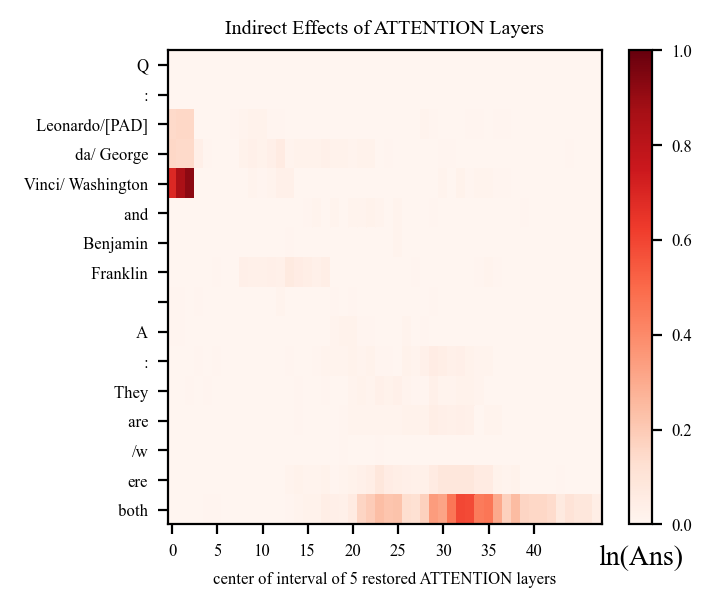

In [156]:
from src.trace import trace_important_states
from src.utils.typing import TokenizerOutput
from src.plotting import plot_trace_heatmap
from src.functional import predict_next_token

patch_entity = sample['entity_pair'][0]
clean_entity = sample["alt_first"]["entity"]

prompt_template = clean_prompt.prompt.replace(clean_entity, "{}")

# for kind in ["residual", "mlp", "attention"]:
for kind in ["attention"]:
    trace_results = trace_important_states(
        mt=mt,
        prompt_template=prompt_template,
        clean_subj=clean_entity,
        patched_subj=patch_entity,
        clean_input=TokenizerOutput(data=clean_prompt.tokenized),
        patched_input=TokenizerOutput(data=patch_prompt.tokenized),
        trace_start_marker="#",
        metric=METRIC,
        # normalize=False,
        kind=kind,
        window_size=1 if kind == "residual" else 5,
        ans_tokens=keywords
    )

    plot_trace_heatmap(
        result=trace_results,
        model_name=model_key.split("/")[-1],
        scale_range=(0, 1) if trace_results.normalized == True else None
    )

In [157]:
from src.tokens import align_patching_positions

aligned_prompts = align_patching_positions(
    mt = mt,
    prompt_template = patch_prompt.prompt.replace(patch_prompt.entities[0], "{}"),
    clean_subj = clean_prompt.entities[0],
    patched_subj = patch_prompt.entities[0],
    trace_start_marker="#"
)

aligned_prompts["subj_range"]
# aligned_prompts["clean_input"]

(205, 208)

In [158]:
from src.probing.utils import ProbingPrompt
from src.utils.typing import TokenizerOutput

e1_range = aligned_prompts["subj_range"]

shift = e1_range[1] - clean_prompt.entity_ranges[0][1]

e2_range = clean_prompt.entity_ranges[1]
e2_range = (
    e2_range[0] + shift,
    e2_range[1] + shift
)

tokenized_input = TokenizerOutput(data = aligned_prompts["clean_input"])
print(f'"{mt.tokenizer.decode(tokenized_input.input_ids[0][e1_range[0] : e1_range[1]])}"')
print(f'"{mt.tokenizer.decode(tokenized_input.input_ids[0][e2_range[0] : e2_range[1]])}"')

tokenized_patch_input = TokenizerOutput(data = aligned_prompts["patched_input"])
print(f'"{mt.tokenizer.decode(tokenized_patch_input.input_ids[0][e1_range[0] : e1_range[1]])}"')

aligned_clean_prompt = ProbingPrompt(
    prompt = mt.tokenizer.decode(aligned_prompts["clean_input"]["input_ids"][0]),
    entities = clean_prompt.entities,

    model_key = clean_prompt.model_key,
    tokenized=aligned_prompts["clean_input"],

    entity_ranges = [e1_range, e2_range],

    query_range=[-1, -1]
)

aligned_patch_prompt = ProbingPrompt(
    prompt = mt.tokenizer.decode(aligned_prompts["patched_input"]["input_ids"][0]),
    entities = patch_prompt.entities,

    model_key = patch_prompt.model_key,
    tokenized=aligned_prompts["patched_input"],

    entity_ranges = [e1_range, e2_range],

    query_range=[-1, -1]
)

"<|endoftext|> George Washington"
" Benjamin Franklin"
" Leonardo da Vinci"


## Ablation

In [159]:
from src.functional import PatchSpec, generate_with_patch, interpret_logits, get_hs
from src.trace import get_score
from src.utils.typing import TokenizerOutput
from typing import Literal

@torch.inference_mode()
def patched_run(
    mt: ModelandTokenizer,
    inputs: TokenizerOutput,
    ans_tokens: list[int],
    patches: list[PatchSpec] = [],
    metric: Literal["logit", "prob", "log_norm"] = "logit",
    generate_full_ans: bool = False,
    patch_at_all_generations: bool = False,
    cache_locations: list[tuple[str, int]] = [],
    **next_tok_kwargs
):
    if generate_full_ans:
        answer = generate_with_patch(
            mt = mt,
            inputs = inputs,
            n_gen_per_prompt=1,
            do_sample=False,
            patches = patches,
            patch_strategy="replace",
            remove_prefix=True,
            patch_at_all_generations=patch_at_all_generations,
            # use_cache = False,
        )
        answer = answer[0].split('\n')[0]
        print(f"\"{answer}\"")
    
    logit_pos = (mt.lm_head_name, -1)
    hs = get_hs(
        mt = mt,
        input = inputs,
        locations = list(set(cache_locations + [logit_pos])),
        patches = patches,
        return_dict=True
    )

    logits = hs[logit_pos].squeeze(0)
    hs.pop(logit_pos)

    pred, track = interpret_logits(
        tokenizer=mt,
        logits=logits,
        interested_tokens=ans_tokens,
        **next_tok_kwargs
    )

    score = get_score(logits = logits, token_id=ans_tokens, metric = metric)

    return dict(
        score=score,
        pred=pred,
        track=track,
        hs=hs,
    )

In [ ]:

#! do different MLPs favor different associations?
#! all the critical range of layers varies by examples
#! the hydra effect seems very prominent
#! peak deception => let's say the score peaks at some region, it doesn't necessairily mean that is the most important region

# locations = [(mt.mlp_module_name_format.format(l), -1) for l in range(30, mt.n_layer)] # breaks the LM
# locations = [(mt.mlp_module_name_format.format(l), -1) for l in range(41, mt.n_layer)]
# locations = [(mt.mlp_module_name_format.format(l), -1) for l in range(30, 38)] # small behavioral changes     
# locations = [(mt.mlp_module_name_format.format(l), -1) for l in range(30, 41)]

# locations = [(mt.attn_module_name_format.format(l), -1) for l in range(25, mt.n_layer)] # breaks the LM
# locations = [(mt.attn_module_name_format.format(l), -1) for l in range(40, mt.n_layer)] # attn doesn't contribute that much in the very late layers
# locations = [(mt.attn_module_name_format.format(l), -1) for l in range(24, 41)] # critical attn layers -- varies by examples


#####################################################################################
# ABLATION_LAYER_NAME_FORMAT = mt.mlp_module_name_format
ABLATION_LAYER_NAME_FORMAT = mt.attn_module_name_format
ABLATION_RANGE = (47, 47) #* don't ablate anything

# ABLATION_RANGE = (24, 41)
# ABLATION_RANGE = (26, 40)
# ABLATION_RANGE = (40, 47)
# ABLATION_RANGE = (35, 43)
# ABLATION_RANGE = (20, 44)

# ABLATION_RANGE = (5, 30) # MLPs in this range can be ablated pretty safely
# ABLATION_RANGE = (33, 43) # MLP critical range from tracing ==> varies by examples
# ABLATION_RANGE = (30, 47) # Breaks the LM
# ABLATION_RANGE = (30, 42) # Leave very later MLPs

ABLATION_RANGE = (28, 39)

# ----------------------------------------------------------------------------------

FREEZE_LAYER_NAME_FORMAT = mt.mlp_module_name_format
# FREEZE_LAYER_NAME_FORMAT = mt.attn_module_name_format
FREEZE_RANGE = (47, 47) #* don't freeze anything

# FREEZE_RANGE = (43, mt.n_layer) # freeze the later MLPs so that they can't recover the damage
# FREEZE_RANGE = (45, mt.n_layer) # freeze very late layers while keep some immediate next MLPs to see if they can recover the damage.
# FREEZE_RANGE = (43, 46) # freeze the layers immediately after the ablated layers, while keeping the later layers to see if they can recover the damage. 
#####################################################################################

# FREEZE_RANGE, ABLATION_RANGE = ABLATION_RANGE, FREEZE_RANGE #* for testing


patched_inputs = TokenizerOutput(data = aligned_patch_prompt.tokenized)
# patched_inputs = TokenizerOutput(data = prompt.tokenized)
last_tok_locations = (
    [(mt.layer_name_format.format(l), -1) for l in range(0, mt.n_layer)]
    + [(mt.mlp_module_name_format.format(l), -1) for l in range(0, mt.n_layer)]
    + [(mt.attn_module_name_format.format(l), -1) for l in range(0, mt.n_layer)]
)

gold_run = patched_run(
    mt = mt,
    inputs = patched_inputs,
    patches = [],
    ans_tokens = keywords,
    metric = METRIC,
    generate_full_ans=True,
    cache_locations=last_tok_locations,
)

print(f"{gold_run['score']=}")
print(f"{gold_run['pred']=}")
print(f"{gold_run['track']=}")

print('-' * 100)


clean_inputs = TokenizerOutput(data = aligned_clean_prompt.tokenized)
clean_run = patched_run(
    mt = mt,
    inputs = clean_inputs,
    ans_tokens = keywords,
    metric = METRIC,
    generate_full_ans=True,
    cache_locations=last_tok_locations,
)

print(f"{clean_run['score']=}")
print(f"{clean_run['pred']=}")
print(f"{clean_run['track']=}")

print('-' * 100)

ablation_locations = [(ABLATION_LAYER_NAME_FORMAT.format(l), -1) for l in range(*ABLATION_RANGE)]
zero_ablation = torch.zeros(mt.n_embd, device=mt.device)
zero_patches = [
    PatchSpec(
        location = loc,
        patch = zero_ablation,
    ) for loc in ablation_locations
]

freeze_locations = [(FREEZE_LAYER_NAME_FORMAT.format(l), -1) for l in range(*FREEZE_RANGE)]
freeze_patches = [
    PatchSpec(
        location = loc,
        patch = clean_run["hs"][loc],
    ) for loc in freeze_locations
]

ablated_run = patched_run(
    mt = mt,
    inputs = patched_inputs,
    patches = zero_patches,   # just ablation
    # patches = freeze_patches, # just freeze
    # patches = zero_patches + freeze_patches, # ablation + corruption
    patch_at_all_generations=True,
    ans_tokens = keywords,
    metric = METRIC,
    generate_full_ans=True,
    cache_locations=last_tok_locations,
)

print(f"{ablated_run['score']=}")
print(f"{ablated_run['pred']=}")
print(f"{ablated_run['track']=}")

print('-' * 100)


indirect_effect = (ablated_run["score"] - clean_run["score"]) / (gold_run["score"] - clean_run["score"])
print(f"{indirect_effect=}")

" polymaths."
gold_run['score']=3.25
gold_run['pred']=[PredictedToken(token=' polym', prob=0.44140625, logit=19.5, token_id=44933, metadata=None), PredictedToken(token=' invent', prob=0.07666015625, logit=17.75, token_id=17023, metadata=None), PredictedToken(token=' artists', prob=0.052734375, logit=17.375, token_id=13511, metadata=None), PredictedToken(token=' famous', prob=0.052734375, logit=17.375, token_id=11245, metadata=None), PredictedToken(token=' Renaissance', prob=0.046630859375, logit=17.25, token_id=54283, metadata=None)]
gold_run['track']={44933: (1, PredictedToken(token=' polym', prob=0.44140625, logit=19.5, token_id=44933, metadata=None))}
----------------------------------------------------------------------------------------------------
" American politicians."
clean_run['score']=-4.875
clean_run['pred']=[PredictedToken(token=' American', prob=0.1923828125, logit=18.25, token_id=3693, metadata=None), PredictedToken(token=' US', prob=0.0908203125, logit=17.5, token_id=2

100%|██████████| 48/48 [00:04<00:00, 10.20it/s]


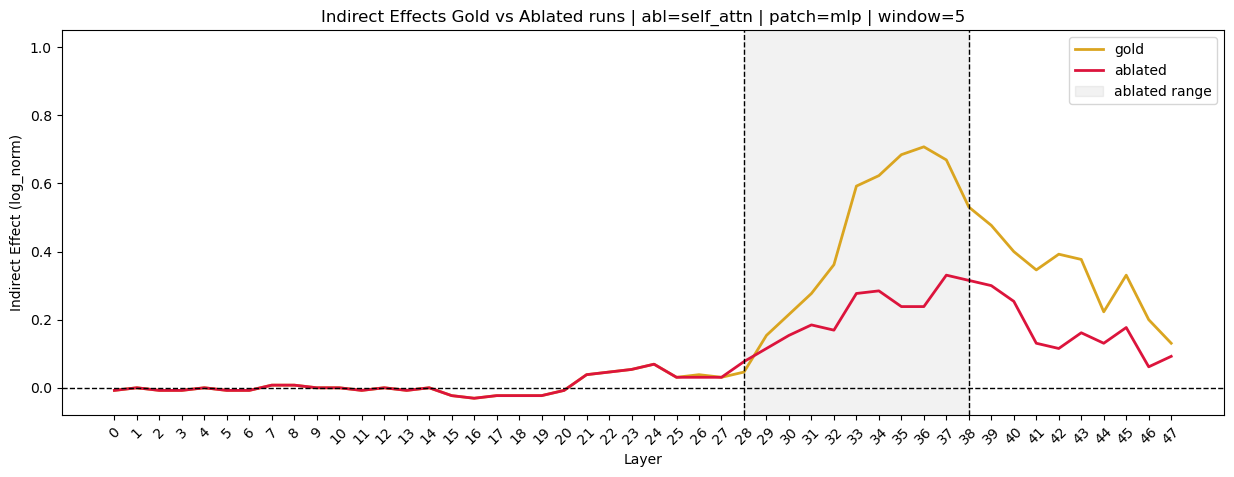

In [176]:
from src.trace import calculate_indirect_effects

#########################################################################
WINDOW_SIZE = 5
# PATCH_LAYER_NAME_FORMAT = ABLATION_LAYER_NAME_FORMAT
PATCH_LAYER_NAME_FORMAT = mt.mlp_module_name_format
#########################################################################

int_locations = [(l, -1) for l in range(0, mt.n_layer)]

gold_ie = calculate_indirect_effects(
    mt = mt,
    locations = int_locations,
    clean_input = clean_inputs,
    patch_states = gold_run["hs"],
    patch_ans_t=keywords,
    layer_name_format=PATCH_LAYER_NAME_FORMAT,
    window_size=WINDOW_SIZE,
    metric=METRIC,
)

ablated_ie = calculate_indirect_effects(
    mt = mt,
    locations = int_locations,
    clean_input = clean_inputs,
    patch_states = ablated_run["hs"],
    patch_ans_t=keywords,
    layer_name_format=PATCH_LAYER_NAME_FORMAT,
    window_size=WINDOW_SIZE,
    metric=METRIC,
)


gold_ie = torch.Tensor([gold_ie[(l, -1)] for l in range(0, mt.n_layer)])
ablated_ie = torch.Tensor([ablated_ie[(l, -1)] for l in range(0, mt.n_layer)])

gold_ie = (gold_ie - clean_run["score"]) / (gold_run["score"] - clean_run["score"])
ablated_ie = (ablated_ie - clean_run["score"]) / (gold_run["score"] - clean_run["score"])


import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.title(f"Indirect Effects Gold vs Ablated runs | abl={ABLATION_LAYER_NAME_FORMAT.split('.')[-1]} | patch={PATCH_LAYER_NAME_FORMAT.split('.')[-1]} | window={WINDOW_SIZE}")

plt.plot(gold_ie, label="gold", color="goldenrod", linewidth=2)
plt.plot(ablated_ie, label="ablated", color="crimson", linewidth=2)

max_y = max(gold_ie.max(), ablated_ie.max(), 1)
min_y = min(gold_ie.min(), ablated_ie.min())
plt.ylim(bottom = min_y - 0.05, top = max_y + 0.05)
plt.xticks(
    ticks=range(0, mt.n_layer),
    labels=[f"{i}" for i in range(0, mt.n_layer)],
    rotation=45,
)

plt.axhline(0, color="black", linestyle="--", linewidth=1)

if ABLATION_RANGE is not None and ABLATION_RANGE[1] > ABLATION_RANGE[0]:
    plt.axvline(ABLATION_RANGE[0], color="black", linestyle="--", linewidth=1)
    plt.axvline(ABLATION_RANGE[1] - 1, color="black", linestyle="--", linewidth=1)
    plt.fill_between(
        range(ABLATION_RANGE[0], ABLATION_RANGE[1]),
        min_y - 0.05,
        max_y + 0.05,
        color="gray",
        alpha=0.1,
        label="ablated range",
    )

if FREEZE_RANGE is not None and FREEZE_RANGE[1] > FREEZE_RANGE[0]:
    plt.axvline(FREEZE_RANGE[0], color="black", linestyle="--", linewidth=1)
    plt.axvline(FREEZE_RANGE[1] - 1, color="black", linestyle="--", linewidth=1)
    plt.fill_between(
        range(FREEZE_RANGE[0], FREEZE_RANGE[1]),
        min_y - 0.05,
        max_y + 0.05,
        color="blue",
        alpha=0.1,
        label="freeze range",
    )

plt.xlabel("Layer")
plt.ylabel(f"Indirect Effect ({METRIC})")

plt.legend()
plt.show()
